In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import json
import math
import os
from tensorflow import keras
import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average, Input, Concatenate, GlobalMaxPooling2D,BatchNormalization
#from keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.applications.xception import Xception
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
# from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

In [ ]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)

            img = cv2.resize(img, (RESIZE,RESIZE))

            IMG.append(np.array(img))
    return IMG

In [ ]:
normal_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/normal',224))
osteoarthritis_train = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/train/osteoarthritis',224))
normal_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/normal',224))
osteoarthritis_test = np.array(Dataset_loader('/content/drive/My Drive/research/knee_eye_test/knee_data/test/osteoarthritis',224))

100%|██████████| 276/276 [00:02<00:00, 96.31it/s]


In [ ]:
print(len(normal_train))
print(len(osteoarthritis_train))
print(len(normal_test))
print(len(osteoarthritis_test))

1020
1550
569
276


In [ ]:
# Create labels
normal_train_label = np.zeros(len(normal_train))
osteoarthritis_train_label = np.ones(len(osteoarthritis_train))
normal_test_label = np.zeros(len(normal_test))
osteoarthritis_test_label = np.ones(len(osteoarthritis_test))

In [ ]:
# Merge data
X_train = np.concatenate((normal_train, osteoarthritis_train), axis = 0)
Y_train = np.concatenate((normal_train_label, osteoarthritis_train_label), axis = 0)
X_test = np.concatenate((normal_test, osteoarthritis_test), axis = 0)
Y_test = np.concatenate((normal_test_label, osteoarthritis_test_label), axis = 0)

In [ ]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]


In [ ]:
# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train,
    test_size=0.2,
    random_state=11
)

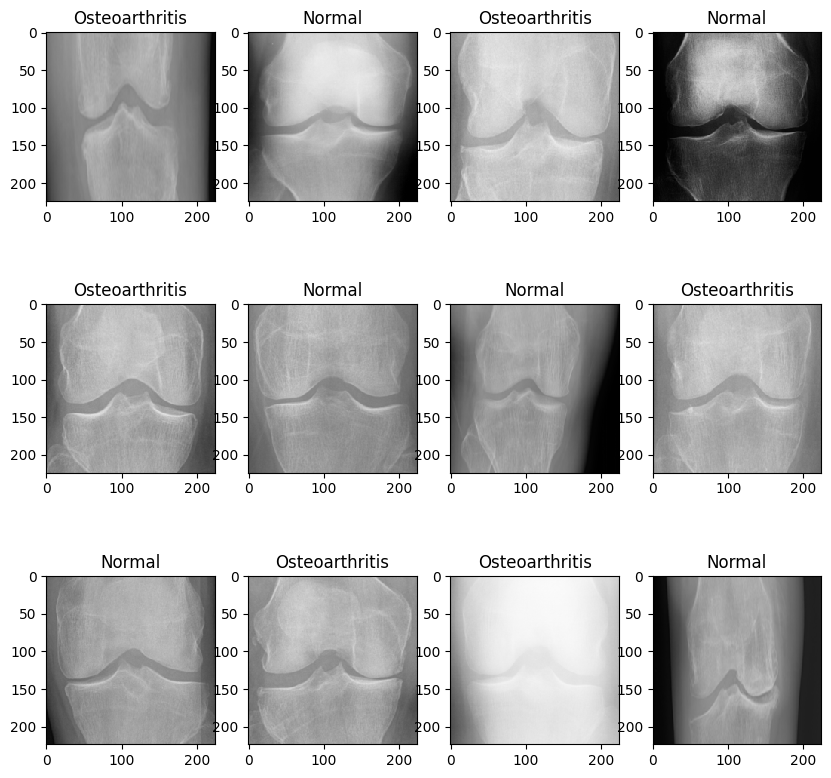

In [ ]:
# # Display first 15 images of moles, and how they are classified
# # Here IDC (+) means Benign
# # IDC (-) means Malignant
w=60
h=40
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Normal')
    else:
        ax.title.set_text('Osteoarthritis')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [ ]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        # zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        shear_range = 0.5,
        width_shift_range=0.4,
        height_shift_range=0.4,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True  # randomly flip images
    )

In [ ]:
IMAGE_SIZE=224
# Model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
inputs = Input(input_shape)

dennet   = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
# nas      = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=input_shape)(inputs)
# vgg      = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape)(inputs)

In [ ]:
outputs = GlobalAveragePooling2D()(dennet)
# Concatenate(axis=-1)([GlobalAveragePooling2D()(vgg), GlobalAveragePooling2D()(nas)])
# outputs = Dropout(0.4)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(32,activation='relu')(outputs)
# outputs = Dropout(0.2)(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dense(2, activation='softmax')(outputs)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(lr=0.0001, decay=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 batch_normalization_95 (Ba  (None, 32)                128   

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="/content/drive/My Driveweights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [ ]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=40,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

<ipython-input-16-9d9ad6683064>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/40
65/64 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.6644

64/64 [==============================] - 56s 622ms/step - loss: 0.6732 - accuracy: 0.6644 - val_loss: 0.6629 - val_accuracy: 0.5992 - lr: 1.0000e-04
Epoch 2/40
65/64 [==============================] - ETA: 0s - loss: 0.5128 - accuracy: 0.7743

64/64 [==============================] - 32s 493ms/step - loss: 0.5128 - accuracy: 0.7743 - val_loss: 0.7222 - val_accuracy: 0.5603 - lr: 1.0000e-04
Epoch 3/40
65/64 [==============================] - ETA: 0s - loss: 0.4576 - accuracy: 0.7952

64/64 [==============================] - 34s 528ms/step - loss: 0.4576 - accuracy: 0.7952 - val_loss: 0.6965 - val_accuracy: 0.6693 - lr: 1.0000e-04
Epoch 4/40
65/64 [==============================] - ETA: 0s - loss: 0.3934 - accuracy: 0.8473

64/64 [==============================] - 32s 501ms/step - loss: 0.3934 - accuracy: 0.8473 - val_loss: 0.5247 - val_accuracy: 0.8054 - lr: 1.0000e-04
Epoch 5/40
65/64 [==============================] - ETA: 0s - loss: 0.3775 - accuracy: 0.8444

64/64 [==============================] - 34s 532ms/step - loss: 0.3775 - accuracy: 0.8444 - val_loss: 0.2658 - val_accuracy: 0.8949 - lr: 1.0000e-04
Epoch 6/40
65/64 [==============================] - ETA: 0s - loss: 0.3425 - accuracy: 0.8619

64/64 [==============================] - 33s 513ms/step - loss: 0.3425 - accuracy: 0.8619 - val_loss: 0.2671 - val_accuracy: 0.8988 - lr: 1.0000e-04
Epoch 7/40
65/64 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8769

64/64 [==============================] - 34s 531ms/step - loss: 0.3270 - accuracy: 0.8769 - val_loss: 0.3640 - val_accuracy: 0.8774 - lr: 1.0000e-04
Epoch 8/40
65/64 [==============================] - ETA: 0s - loss: 0.2889 - accuracy: 0.8804

64/64 [==============================] - 32s 503ms/step - loss: 0.2889 - accuracy: 0.8804 - val_loss: 0.2914 - val_accuracy: 0.9086 - lr: 1.0000e-04
Epoch 9/40
65/64 [==============================] - ETA: 0s - loss: 0.2917 - accuracy: 0.8925

64/64 [==============================] - 34s 533ms/step - loss: 0.2917 - accuracy: 0.8925 - val_loss: 0.8769 - val_accuracy: 0.8016 - lr: 1.0000e-04
Epoch 10/40
65/64 [==============================] - ETA: 0s - loss: 0.2819 - accuracy: 0.8915

64/64 [==============================] - 33s 518ms/step - loss: 0.2819 - accuracy: 0.8915 - val_loss: 0.3629 - val_accuracy: 0.9066 - lr: 1.0000e-04
Epoch 11/40
65/64 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.8935

64/64 [==============================] - 32s 495ms/step - loss: 0.2729 - accuracy: 0.8935 - val_loss: 0.1950 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 12/40
65/64 [==============================] - ETA: 0s - loss: 0.2677 - accuracy: 0.8949

64/64 [==============================] - 32s 509ms/step - loss: 0.2677 - accuracy: 0.8949 - val_loss: 0.2715 - val_accuracy: 0.9280 - lr: 1.0000e-04
Epoch 13/40
65/64 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.8920

64/64 [==============================] - 33s 506ms/step - loss: 0.2729 - accuracy: 0.8920 - val_loss: 0.7228 - val_accuracy: 0.8463 - lr: 1.0000e-04
Epoch 14/40
65/64 [==============================] - ETA: 0s - loss: 0.2538 - accuracy: 0.9052

64/64 [==============================] - 34s 527ms/step - loss: 0.2538 - accuracy: 0.9052 - val_loss: 0.2073 - val_accuracy: 0.9280 - lr: 1.0000e-04
Epoch 15/40
65/64 [==============================] - ETA: 0s - loss: 0.2580 - accuracy: 0.9052

64/64 [==============================] - 33s 512ms/step - loss: 0.2580 - accuracy: 0.9052 - val_loss: 0.2215 - val_accuracy: 0.9377 - lr: 1.0000e-04
Epoch 16/40
65/64 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9066

64/64 [==============================] - 35s 539ms/step - loss: 0.2495 - accuracy: 0.9066 - val_loss: 0.1817 - val_accuracy: 0.9397 - lr: 1.0000e-04
Epoch 17/40
65/64 [==============================] - ETA: 0s - loss: 0.2178 - accuracy: 0.9178

64/64 [==============================] - 33s 507ms/step - loss: 0.2178 - accuracy: 0.9178 - val_loss: 0.3610 - val_accuracy: 0.9008 - lr: 1.0000e-04
Epoch 18/40
65/64 [==============================] - ETA: 0s - loss: 0.2254 - accuracy: 0.9173

64/64 [==============================] - 35s 547ms/step - loss: 0.2254 - accuracy: 0.9173 - val_loss: 0.3660 - val_accuracy: 0.9105 - lr: 1.0000e-04
Epoch 19/40
65/64 [==============================] - ETA: 0s - loss: 0.2236 - accuracy: 0.9115

64/64 [==============================] - 35s 533ms/step - loss: 0.2236 - accuracy: 0.9115 - val_loss: 0.1605 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 20/40
65/64 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9129

64/64 [==============================] - 33s 509ms/step - loss: 0.2246 - accuracy: 0.9129 - val_loss: 0.1628 - val_accuracy: 0.9377 - lr: 1.0000e-04
Epoch 21/40
65/64 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9139

64/64 [==============================] - 34s 520ms/step - loss: 0.2085 - accuracy: 0.9139 - val_loss: 0.1743 - val_accuracy: 0.9280 - lr: 1.0000e-04
Epoch 22/40
65/64 [==============================] - ETA: 0s - loss: 0.2137 - accuracy: 0.9202

64/64 [==============================] - 35s 551ms/step - loss: 0.2137 - accuracy: 0.9202 - val_loss: 0.3095 - val_accuracy: 0.8988 - lr: 1.0000e-04
Epoch 23/40
65/64 [==============================] - ETA: 0s - loss: 0.1981 - accuracy: 0.9290

64/64 [==============================] - 33s 512ms/step - loss: 0.1981 - accuracy: 0.9290 - val_loss: 0.4095 - val_accuracy: 0.8833 - lr: 1.0000e-04
Epoch 24/40
65/64 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9236

64/64 [==============================] - 35s 545ms/step - loss: 0.2036 - accuracy: 0.9236 - val_loss: 0.1562 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 25/40
65/64 [==============================] - ETA: 0s - loss: 0.1939 - accuracy: 0.9246

64/64 [==============================] - 33s 512ms/step - loss: 0.1939 - accuracy: 0.9246 - val_loss: 0.2389 - val_accuracy: 0.9202 - lr: 1.0000e-04
Epoch 26/40
65/64 [==============================] - ETA: 0s - loss: 0.2271 - accuracy: 0.9105

64/64 [==============================] - 33s 507ms/step - loss: 0.2271 - accuracy: 0.9105 - val_loss: 0.1572 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 27/40
65/64 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9232

64/64 [==============================] - 34s 536ms/step - loss: 0.1976 - accuracy: 0.9232 - val_loss: 0.2088 - val_accuracy: 0.9163 - lr: 1.0000e-04
Epoch 28/40
65/64 [==============================] - ETA: 0s - loss: 0.1913 - accuracy: 0.9256

64/64 [==============================] - 33s 513ms/step - loss: 0.1913 - accuracy: 0.9256 - val_loss: 0.1714 - val_accuracy: 0.9494 - lr: 1.0000e-04
Epoch 29/40
65/64 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9149

64/64 [==============================] - 32s 499ms/step - loss: 0.2085 - accuracy: 0.9149 - val_loss: 0.1965 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 30/40
65/64 [==============================] - ETA: 0s - loss: 0.2081 - accuracy: 0.9197

64/64 [==============================] - 32s 500ms/step - loss: 0.2081 - accuracy: 0.9197 - val_loss: 0.1501 - val_accuracy: 0.9533 - lr: 1.0000e-04
Epoch 31/40
65/64 [==============================] - ETA: 0s - loss: 0.1898 - accuracy: 0.9241

64/64 [==============================] - 34s 521ms/step - loss: 0.1898 - accuracy: 0.9241 - val_loss: 0.1831 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 32/40
65/64 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9256

64/64 [==============================] - 32s 500ms/step - loss: 0.1963 - accuracy: 0.9256 - val_loss: 0.1716 - val_accuracy: 0.9436 - lr: 1.0000e-04
Epoch 33/40
65/64 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9358

64/64 [==============================] - 33s 506ms/step - loss: 0.1779 - accuracy: 0.9358 - val_loss: 0.1540 - val_accuracy: 0.9494 - lr: 1.0000e-04
Epoch 34/40
65/64 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9309

64/64 [==============================] - 31s 486ms/step - loss: 0.1774 - accuracy: 0.9309 - val_loss: 0.1866 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 35/40
65/64 [==============================] - ETA: 0s - loss: 0.1822 - accuracy: 0.9334

64/64 [==============================] - 33s 515ms/step - loss: 0.1822 - accuracy: 0.9334 - val_loss: 0.1680 - val_accuracy: 0.9416 - lr: 1.0000e-04
Epoch 36/40
65/64 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9324

64/64 [==============================] - 31s 486ms/step - loss: 0.1744 - accuracy: 0.9324 - val_loss: 0.1372 - val_accuracy: 0.9553 - lr: 1.0000e-04
Epoch 37/40
65/64 [==============================] - ETA: 0s - loss: 0.1757 - accuracy: 0.9256

64/64 [==============================] - 33s 508ms/step - loss: 0.1757 - accuracy: 0.9256 - val_loss: 0.2225 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 38/40
65/64 [==============================] - ETA: 0s - loss: 0.1665 - accuracy: 0.9402

64/64 [==============================] - 32s 490ms/step - loss: 0.1665 - accuracy: 0.9402 - val_loss: 0.2270 - val_accuracy: 0.9358 - lr: 1.0000e-04
Epoch 39/40
65/64 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9339

64/64 [==============================] - 34s 528ms/step - loss: 0.1773 - accuracy: 0.9339 - val_loss: 0.2337 - val_accuracy: 0.9241 - lr: 1.0000e-04
Epoch 40/40
65/64 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9363

64/64 [==============================] - 33s 505ms/step - loss: 0.1739 - accuracy: 0.9363 - val_loss: 0.1363 - val_accuracy: 0.9533 - lr: 1.0000e-04


17/17 [==============================] - 2s 67ms/step
Confusion matrix, without normalization
[[207   9]
 [ 15 283]]


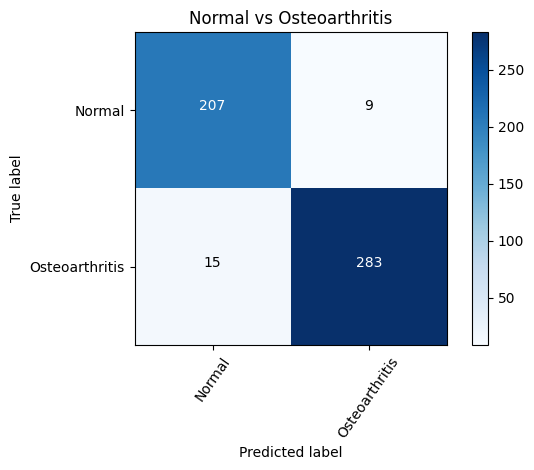

In [ ]:
Y_pred = model.predict(x_val)
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['Normal', 'Osteoarthritis']
plot_confusion_matrix(cm, cm_plot_label, title ='Normal vs Osteoarthritis')

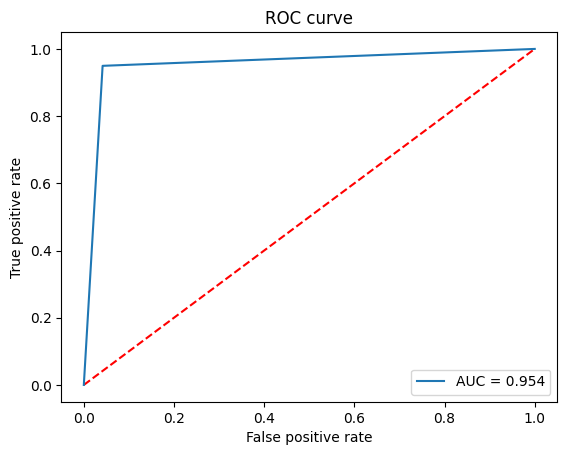

In [ ]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

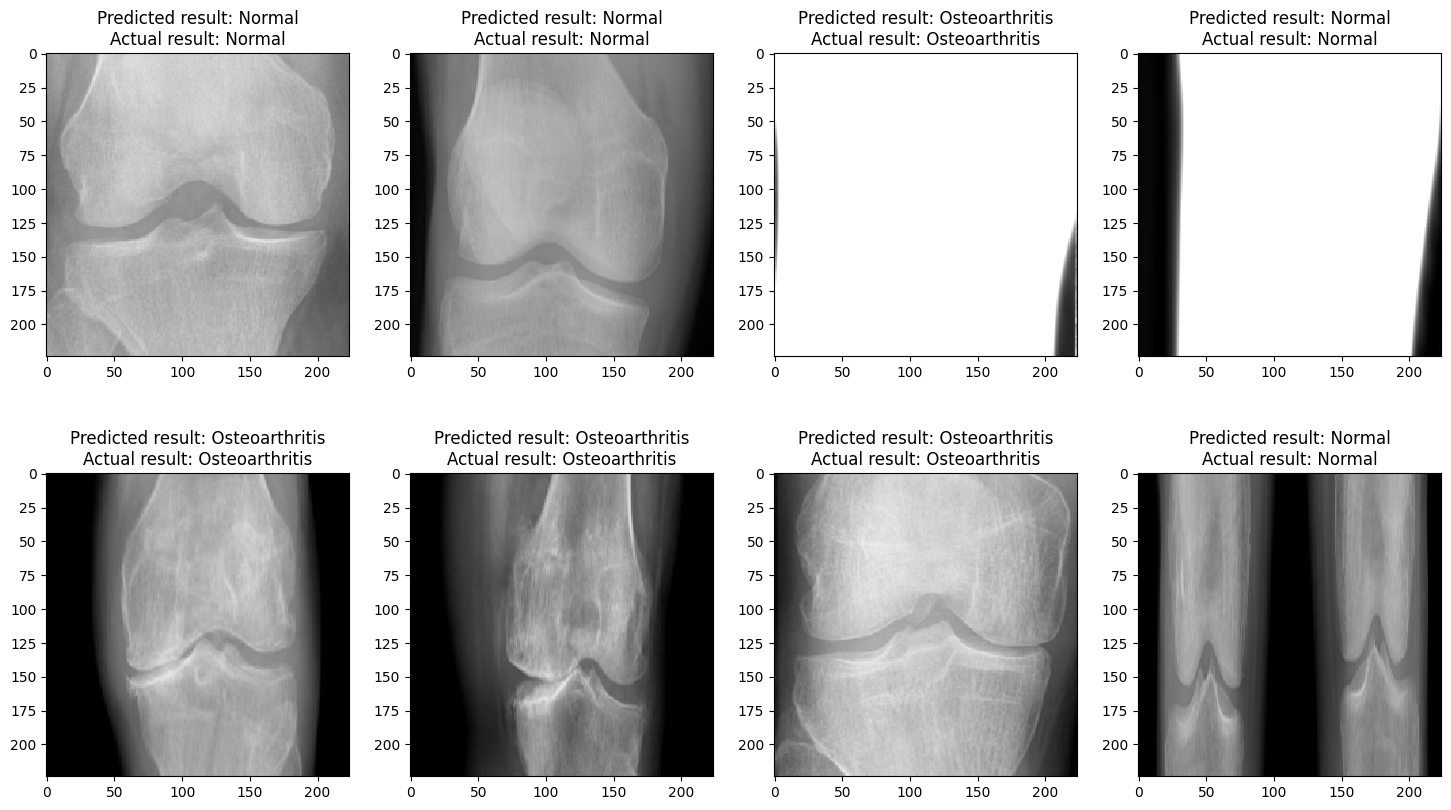

In [ ]:

i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Normal"
    else:
        return "Osteoarthritis"

for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result: "+ Transfername(np.argmax(Y_pred[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

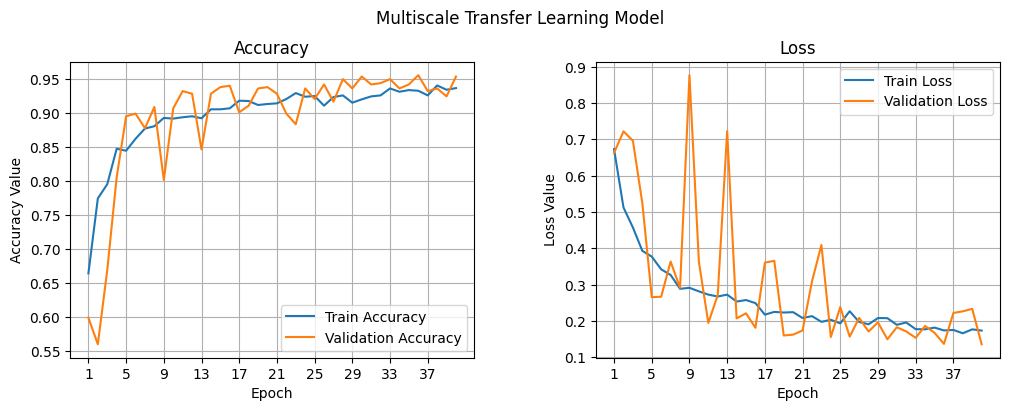

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Multiscale Transfer Learning Model', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,41))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.grid()
ax1.set_xticks(np.arange(1, 41, 4))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.grid()
ax2.set_xticks(np.arange(1, 41, 4))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

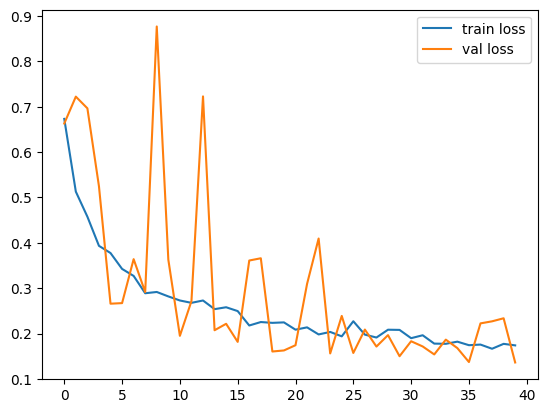

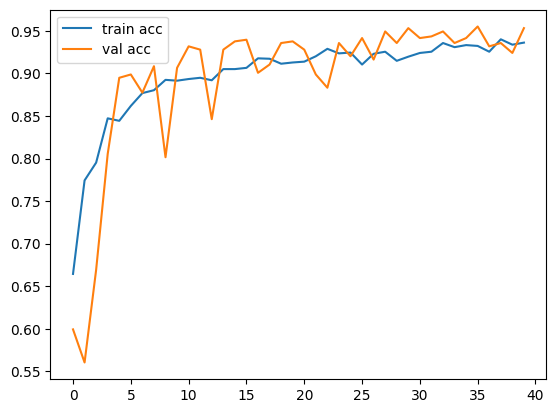

In [ ]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
pred=model.predict(x_val)
Y_pred = np.argmax(pred, 1)
y_test=np.argmax(y_val,1)

17/17 [==============================] - 1s 65ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print('Classification Report')
target_names = ['Osteoarthritis', 'Normal']
print(classification_report(y_test, Y_pred, target_names=target_names))

Classification Report
                precision    recall  f1-score   support

Osteoarthritis       0.93      0.96      0.95       216
        Normal       0.97      0.95      0.96       298

      accuracy                           0.95       514
     macro avg       0.95      0.95      0.95       514
  weighted avg       0.95      0.95      0.95       514

